In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

In [45]:
# 0. Setup
N, M = 7, 7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.8)
p_true= np.array(0.95)
big_reward_true = np.array([0.9, 0.6])

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = big_reward_true[0]
agent_R[0, M-1] = big_reward_true[1]
# agent_R[N-1, M-1] = big_reward_true[2]
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]


#medium wall states
wall_states = []
wall_states.append(1*N+2)
wall_states.append(1*N+3)
wall_states.append(4*N+1)
wall_states.append(4*N+2)
wall_states.append(4*N+5)
wall_states.append(4*N+6)

#easy wall states
# wall_states = []
# wall_states.append(5*N+1)
# wall_states.append(6*N+1)
# wall_states.append(1*N+M-1)
# wall_states.append(1*N+M-2)

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()


#Create parameter ranges
resolution = 20
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range_1 = np.linspace(0.3, 0.95, resolution)
R_range_2 = np.linspace(0.3, 0.95, resolution)
# R_range_3 = np.linspace(0.3, 0.95, resolution)
R_range = np.array([R_range_1, R_range_2])

gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(len(R_range), resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(len(R_range), 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




maze = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [47]:
def run_all_methods(environment_name, true_params, environment, n_runs=3):

    method_names = ["BIRL", "AMBER", "ED-BIRL"]

    for method_name in method_names:

        print("\n\n\n" + method_name + "\n\n\n")

        if method_name == "BIRL":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "BIRL"

        elif method_name == "ED-BIRL":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "ED-BIRL"
            candidate_environments_args["n_environments"] = 150
            candidate_environments_args["n_walls"] = 5
            candidate_environments_args["how"] = "value"

        elif method_name == "AMBER_random":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "AMBER_random"
            candidate_environments_args["n_compute_BM"] = 3
            candidate_environments_args["n_iterations"] = 1
            candidate_environments_args["stepsize"] = 0.0001

        elif method_name == "AMBER":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "AMBER"
            candidate_environments_args["n_compute_BM"] = 100
            candidate_environments_args["n_iterations"] = 1
            candidate_environments_args["stepsize"] = 0.0001

        for idx_run in range(n_runs):

            print("\n\n\n Run " + str(idx_run+1) + "/" + str(n_runs) + "\n\n\n")

            env_design = EnvironmentDesign(base_environment=environment, 
                                           user_params=true_params, 
                                           learn_what = ["R"],
                                           parameter_ranges_R=R_range,
                                           parameter_ranges_gamma=gamma_range,
                                           parameter_ranges_T=p_range)

            env_design.run_n_episodes(n_episodes = 15,
                        candidate_environments_args=candidate_environments_args,
                        verbose=True)

            env_design.save(f"{environment_name}/Rtrue={str(big_reward_true.tolist())}/" + candidate_environments_args["generate_how"])

In [49]:
# all_big_rewards = [np.array([0.6, 0.6]), np.array([0.8, 0.4]), np.array([0.9, 0.3]), np.array([0.6, 0.2])]
all_big_rewards = [np.array([0.9, 0.39])]
all_gammas = [0.8]


for big_reward_true in all_big_rewards:

    big_reward_true = big_reward_true.reshape(len(R_range), 1)

    true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)

    maze = Environment(
        N=N,
        M=M,
        reward_function = custom_reward_func,
        transition_function=custom_transition_func,
        gamma = custom_gamma_func,
        wall_states=wall_states,
        start_state=0,
        goal_states=goal_states
    )

    run_all_methods("medium_maze", true_params, environment=maze, n_runs=5)




BIRL






 Run 1/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.


/tmp/ipykernel_7431/3374587908.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, 0] = big_reward_1
/tmp/ipykernel_7431/3374587908.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[0,M-1] = big_reward_2


Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7345084945635912, 0.4810329795206253]
Computed Region of Interest. Size = 0.37
Finished episode 2.
Started episode 3.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7481036320966145, 0.4398299131015692]
Computed Region of Interest. Size = 0.27
Finished episode 3.
Started episode 4.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7709407425942593, 0.4148897728126286]
Computed Region of Interest. Size = 0.2
Finished episode 4.
Started episode 5.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7914678151858224, 0.39

Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s, highest_regret=0.41]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.12it/s, highest_regret=0.407]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7308820798800304, 0.5288943451554586]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.98it/s, highest_regret=1]  


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.762021677601761, 0.5058090786687752]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:47<00:00,  3.15it/s, highest_regret=0.463]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7929455641170238, 0.49336436691745855]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s, highest_regret=0.674]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.824227149293692, 0.49139229981586957]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s, highest_regret=1.11]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8523142125767278, 0.49249077742219394]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:45<00:00,  3.31it/s, highest_regret=0.396]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8748108090580695, 0.49725866684665654]
Computed Region of Interest. Size = 0.15
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:47<00:00,  3.19it/s, highest_regret=0.463]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8910299618865621, 0.4925036010017312]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s, highest_regret=0.743]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9045014762793078, 0.4931332565103794]
Computed Region of Interest. Size = 0.1
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:45<00:00,  3.28it/s, highest_regret=0.797]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9167403700770285, 0.5008161585009222]
Computed Region of Interest. Size = 0.08
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s, highest_regret=0.109]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222679473830041, 0.4764407597195117]
Computed Region of Interest. Size = 0.07
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:40<00:00,  3.72it/s, highest_regret=0.151]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9312001463654329, 0.4956979946396889]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:44<00:00,  3.40it/s, highest_regret=0.465]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9269272016850838, 0.46241391761401185]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:42<00:00,  3.50it/s, highest_regret=0.456]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9235944452723827, 0.450592357449692]
Computed Region of Interest. Size = 0.04
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL/27.05.2024



 Run 2/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:38<00:00,  3.90it/s, highest_regret=0.379]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.07it/s, highest_regret=0.568]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7308820798800304, 0.5288943451554586]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s, highest_regret=1.12]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.762021677601761, 0.5058090786687752]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.94it/s, highest_regret=0.945]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7930171459686309, 0.4933588765491216]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:30<00:00,  4.85it/s, highest_regret=0.0256]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8243055523424395, 0.4914052175936961]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:56<00:00,  2.63it/s, highest_regret=1.18]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8497648321986067, 0.4728749262101965]
Computed Region of Interest. Size = 0.17
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.72it/s, highest_regret=1.06]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8457313395229182, 0.4290314448058596]
Computed Region of Interest. Size = 0.13
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s, highest_regret=0.35]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8495383432355088, 0.40249975083338035]
Computed Region of Interest. Size = 0.11
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.68it/s, highest_regret=1.04]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8693950755553288, 0.39864206242225736]
Computed Region of Interest. Size = 0.09
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:57<00:00,  2.62it/s, highest_regret=0.67]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8868037419554184, 0.39967136014912147]
Computed Region of Interest. Size = 0.07
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:59<00:00,  2.51it/s, highest_regret=1.6]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8989363248292889, 0.3917024890688707]
Computed Region of Interest. Size = 0.06
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:00<00:00,  2.48it/s, highest_regret=1.22]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9129729348202447, 0.3967024065101125]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.72it/s, highest_regret=0.512]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9224457067574103, 0.3984141463306733]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.05it/s, highest_regret=0.837]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9174308208009806, 0.3789626212722821]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL/27.05.2024



 Run 3/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.72it/s, highest_regret=0.737]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.77it/s, highest_regret=0.734]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7308820798800304, 0.5288943451554586]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s, highest_regret=1.07]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.762021677601761, 0.5058090786687752]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.77it/s, highest_regret=0.894]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7930171459686309, 0.4933588765491216]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s, highest_regret=0.799]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8242603408399111, 0.4913933150200603]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:58<00:00,  2.57it/s, highest_regret=0.808]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8484887809298629, 0.49001784760024103]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s, highest_regret=0.573]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8250568343257296, 0.46874628329227397]
Computed Region of Interest. Size = 0.14
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.96it/s, highest_regret=0.595]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8043628853595499, 0.4539728746045676]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.92it/s, highest_regret=0.921]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7875601882870344, 0.4465121376828569]
Computed Region of Interest. Size = 0.09
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s, highest_regret=0.691]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7735790153167866, 0.4470213279500391]
Computed Region of Interest. Size = 0.07
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.69it/s, highest_regret=0.922]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7617630446963578, 0.43655868275249327]
Computed Region of Interest. Size = 0.06
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.73it/s, highest_regret=0.775]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7531714126571426, 0.44263204713527626]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s, highest_regret=1.54]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7455694757575224, 0.45180572327152757]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:02<00:00,  2.40it/s, highest_regret=1.01]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7437395154157449, 0.46169628337151114]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL/27.05.2024



 Run 4/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s, highest_regret=1.01]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.23it/s, highest_regret=0.799]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7301394946805199, 0.5298429290497205]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.09it/s, highest_regret=0.353]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7614387262678645, 0.5066006187565895]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:03<00:00,  2.38it/s, highest_regret=1.18]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.79100922977138, 0.4920633918910884]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.86it/s, highest_regret=0.849]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.824225886986202, 0.4913916020961567]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:42<00:00,  3.51it/s, highest_regret=0.67]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8523136987649576, 0.4924904263770155]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:44<00:00,  3.36it/s, highest_regret=0.469]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8748020961908632, 0.4972598083701928]
Computed Region of Interest. Size = 0.15
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.06it/s, highest_regret=0.854]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.89100604771787, 0.49249291018939767]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.98it/s, highest_regret=0.877]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9044867440546976, 0.49312718144346046]
Computed Region of Interest. Size = 0.1
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.06it/s, highest_regret=0.411]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9167313696262303, 0.5008149962966499]
Computed Region of Interest. Size = 0.08
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:57<00:00,  2.63it/s, highest_regret=0.783]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222591484996244, 0.47643179626118576]
Computed Region of Interest. Size = 0.07
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s, highest_regret=0.46]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9316108764668044, 0.49732061906350816]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:53<00:00,  2.80it/s, highest_regret=0.507]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369894081141492, 0.47269422020018587]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:08<00:00,  2.18it/s, highest_regret=1.4]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419687403423138, 0.4851281635526059]
Computed Region of Interest. Size = 0.04
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL/27.05.2024



 Run 5/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.02it/s, highest_regret=0.411]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6851988092068074, 0.5686915118101915]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:04<00:00,  2.33it/s, highest_regret=1.11]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7308820798800304, 0.5288943451554586]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:47<00:00,  3.14it/s, highest_regret=0.55]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.762021677601761, 0.5058090786687752]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.70it/s, highest_regret=0.999]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7930171459686309, 0.4933588765491216]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:43<00:00,  3.43it/s, highest_regret=0.2]  


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8242603408399111, 0.4913933150200603]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:45<00:00,  3.28it/s, highest_regret=0.357]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8523204752704271, 0.49249022651855123]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.04it/s, highest_regret=0.607]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8748141616171385, 0.4972578832467558]
Computed Region of Interest. Size = 0.15
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.88it/s, highest_regret=0.58]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8910319220467274, 0.49250339557851996]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.06it/s, highest_regret=0.673]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9045026501528094, 0.49313302024514555]
Computed Region of Interest. Size = 0.1
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:43<00:00,  3.49it/s, highest_regret=0.548]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9167410458237301, 0.5008155128573635]
Computed Region of Interest. Size = 0.08
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:41<00:00,  3.60it/s, highest_regret=0.551]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222684825885304, 0.4764410834057734]
Computed Region of Interest. Size = 0.07
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s, highest_regret=1.13]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9316186118381837, 0.49731342203419443]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:47<00:00,  3.13it/s, highest_regret=0.788]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369945169932914, 0.4727004775532674]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.10it/s, highest_regret=0.53]

Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419735494219805, 0.4851288255950731]
Computed Region of Interest. Size = 0.04
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL/27.05.2024


In [31]:
# 0. Setup
N, M = 7, 7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.8)
p_true= np.array(0.95)
big_reward_true = np.array([0.9, 0.6])

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = big_reward_true[0]
agent_R[0, M-1] = big_reward_true[1]
# agent_R[N-1, M-1] = big_reward_true[2]
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]

wall_states = []
# wall_states.append(5*N+1)
# wall_states.append(6*N+1)
# wall_states.append(1*N+M-1)
# wall_states.append(1*N+M-2)


T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()


#Create parameter ranges
resolution = 20
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range_1 = np.linspace(0.3, 0.95, resolution)
R_range_2 = np.linspace(0.3, 0.95, resolution)
# R_range_3 = np.linspace(0.3, 0.95, resolution)
R_range = np.array([R_range_1, R_range_2])

gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(len(R_range), resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(len(R_range), 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




maze = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [32]:
run_all_methods("hard_maze", true_params, n_runs=5)




ED-BIRL






 Run 1/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


/tmp/ipykernel_7431/3831049922.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, 0] = big_reward_1
/tmp/ipykernel_7431/3831049922.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[0,M-1] = big_reward_2
Evaluating candidate environments using value: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, highest_regret=0.284]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6846930215199989, 0.5699034756738509]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.95it/s, highest_regret=1.09]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7304989466056323, 0.5299960181431178]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:43<00:00,  3.49it/s, highest_regret=0.479]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7616975824408962, 0.5070074436680572]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:54<00:00,  2.76it/s, highest_regret=1.01]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.791567185731601, 0.4933252152175448]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s, highest_regret=0.543]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8240348170098104, 0.4913455489847422]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.09it/s, highest_regret=0.545]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8477445219204566, 0.4868904198549256]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.10it/s, highest_regret=0.652]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8747318974102696, 0.497242617852904]
Computed Region of Interest. Size = 0.15
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.04it/s, highest_regret=0.59]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8886736978151738, 0.4890284108696571]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.06it/s, highest_regret=0.75] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9037567028311572, 0.49170473999252845]
Computed Region of Interest. Size = 0.1
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:44<00:00,  3.37it/s, highest_regret=0.382]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9167176496441723, 0.5008187947736672]
Computed Region of Interest. Size = 0.08
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.10it/s, highest_regret=0.439]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222498574613872, 0.4764229777732876]
Computed Region of Interest. Size = 0.07
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:42<00:00,  3.54it/s, highest_regret=0.315]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9307111939417899, 0.49703737524588854]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:53<00:00,  2.81it/s, highest_regret=0.976]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9263592076648377, 0.46892072996182416]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  3.00it/s, highest_regret=0.623]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9211436154939602, 0.4665522177837458]
Computed Region of Interest. Size = 0.04
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/hard_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL/26.05.2024



 Run 2/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.95it/s, highest_regret=0.503]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6846930215199989, 0.5699034756738509]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s, highest_regret=0.759]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7297693380196687, 0.5308904472050368]
Computed Region of Interest. Size = 0.46
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:53<00:00,  2.81it/s, highest_regret=0.944]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7463478681986568, 0.4995183449195205]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.06it/s, highest_regret=0.517]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7110258391461622, 0.46297482581772204]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s, highest_regret=0.93]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6752044513166359, 0.43855806267572095]
Computed Region of Interest. Size = 0.22
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.19it/s, highest_regret=0.469]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6454622304831714, 0.42159371744048285]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:47<00:00,  3.19it/s, highest_regret=0.531]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6429587645231177, 0.405027272738359]
Computed Region of Interest. Size = 0.14
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.88it/s, highest_regret=0.838]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6248269766392943, 0.39250483661966107]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.06it/s, highest_regret=0.501]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6225208115009232, 0.39103446552771787]
Computed Region of Interest. Size = 0.09
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:41<00:00,  3.58it/s, highest_regret=0.294]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6162464254778692, 0.3738558473527359]
Computed Region of Interest. Size = 0.07
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s, highest_regret=0.706]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6227481027248819, 0.36952282593281055]
Computed Region of Interest. Size = 0.06
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:53<00:00,  2.81it/s, highest_regret=0.718]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6194161678441786, 0.36980463666481683]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:42<00:00,  3.53it/s, highest_regret=0.641]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.633587772056689, 0.3734765045567199]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s, highest_regret=0.709]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.642149132194401, 0.3684055011353666]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/hard_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL/26.05.2024



 Run 3/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s, highest_regret=0.571]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6846930215199989, 0.5699034756738509]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s, highest_regret=0.452]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7304989466056323, 0.5299960181431178]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.96it/s, highest_regret=1.02]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7611977996969915, 0.5068662431476709]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.08it/s, highest_regret=0.856]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7908446605873324, 0.49206518115395537]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:43<00:00,  3.48it/s, highest_regret=0.583]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8183535625277184, 0.5063042381299024]
Computed Region of Interest. Size = 0.21
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.71it/s, highest_regret=1.05]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7946537349279762, 0.5228908092050045]
Computed Region of Interest. Size = 0.17
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s, highest_regret=0.42]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7842292609153068, 0.5426151062084973]
Computed Region of Interest. Size = 0.13
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.19it/s, highest_regret=0.31]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7833822603761512, 0.5663644454898248]
Computed Region of Interest. Size = 0.1
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.19it/s, highest_regret=0.699]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7994668086984801, 0.6065131282514429]
Computed Region of Interest. Size = 0.08
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:55<00:00,  2.72it/s, highest_regret=0.722]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8181050199373651, 0.640860164118737]
Computed Region of Interest. Size = 0.06
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.06it/s, highest_regret=0.768]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8229652939819996, 0.6549278804079102]
Computed Region of Interest. Size = 0.05
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:45<00:00,  3.31it/s, highest_regret=0.607]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8251408932444106, 0.665394654139987]
Computed Region of Interest. Size = 0.04
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:43<00:00,  3.47it/s, highest_regret=0.566]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8317352659146934, 0.678392212598952]
Computed Region of Interest. Size = 0.03
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.94it/s, highest_regret=0.675]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8504162520030987, 0.700847831880414]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/hard_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL/26.05.2024



 Run 4/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:50<00:00,  2.94it/s, highest_regret=0.575]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6846930215199989, 0.5699034756738509]
Computed Region of Interest. Size = 0.6
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:58<00:00,  2.58it/s, highest_regret=1.21]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7304989466056323, 0.5299960181431178]
Computed Region of Interest. Size = 0.45
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:00<00:00,  2.47it/s, highest_regret=1.01]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7617081485685223, 0.5068140272943695]
Computed Region of Interest. Size = 0.35
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s, highest_regret=0.402]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.791125190077934, 0.4921493488869836]
Computed Region of Interest. Size = 0.28
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.91it/s, highest_regret=0.609]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8243743609296779, 0.49143447006643903]
Computed Region of Interest. Size = 0.23
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:48<00:00,  3.08it/s, highest_regret=0.642]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8539404588424881, 0.49275892236936]
Computed Region of Interest. Size = 0.18
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:44<00:00,  3.35it/s, highest_regret=0.299]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8761571149584776, 0.4962261134231043]
Computed Region of Interest. Size = 0.14
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:02<00:00,  2.39it/s, highest_regret=0.837]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8923821143577565, 0.49171524734138433]
Computed Region of Interest. Size = 0.12
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:53<00:00,  2.83it/s, highest_regret=0.419]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9049949962421656, 0.4892705080067421]
Computed Region of Interest. Size = 0.1
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:58<00:00,  2.56it/s, highest_regret=0.679]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9185581970753672, 0.501600624195052]
Computed Region of Interest. Size = 0.08
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:07<00:00,  2.21it/s, highest_regret=1.12]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9257769830072075, 0.4887136454866264]
Computed Region of Interest. Size = 0.06
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:01<00:00,  2.45it/s, highest_regret=0.593]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9336085934547945, 0.4970043590541692]
Computed Region of Interest. Size = 0.05
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:59<00:00,  2.52it/s, highest_regret=0.898]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9380526201396864, 0.47449516038672684]
Computed Region of Interest. Size = 0.04
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:57<00:00,  2.59it/s, highest_regret=0.489]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9436044541436164, 0.49667368561360026]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/hard_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL/26.05.2024



 Run 5/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s, highest_regret=0.419]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.701628133076222, 0.5143631259391132]
Computed Region of Interest. Size = 0.48
Finished episode 1.
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:59<00:00,  2.50it/s, highest_regret=0.702]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7295311863657359, 0.4651756616275899]
Computed Region of Interest. Size = 0.34
Finished episode 2.
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:57<00:00,  2.60it/s, highest_regret=0.582]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7509062737027654, 0.43698212472292447]
Computed Region of Interest. Size = 0.26
Finished episode 3.
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:00<00:00,  2.47it/s, highest_regret=0.767]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7705455429041319, 0.41667757305878456]
Computed Region of Interest. Size = 0.2
Finished episode 4.
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:58<00:00,  2.58it/s, highest_regret=0.864]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7925957859865348, 0.40386934200547425]
Computed Region of Interest. Size = 0.16
Finished episode 5.
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:09<00:00,  2.17it/s, highest_regret=0.99] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8204098321206728, 0.3982782721316473]
Computed Region of Interest. Size = 0.13
Finished episode 6.
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:58<00:00,  2.58it/s, highest_regret=0.663]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.845331695126151, 0.3947296084892476]
Computed Region of Interest. Size = 0.1
Finished episode 7.
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.86it/s, highest_regret=0.508]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.866449111439109, 0.3936649812238094]
Computed Region of Interest. Size = 0.09
Finished episode 8.
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 150/150 [01:03<00:00,  2.38it/s, highest_regret=0.815]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8858070316460691, 0.39556576251767345]
Computed Region of Interest. Size = 0.07
Finished episode 9.
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.88it/s, highest_regret=0.276]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8988280493671011, 0.39165176448504535]
Computed Region of Interest. Size = 0.06
Finished episode 10.
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:46<00:00,  3.22it/s, highest_regret=0.356]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.912896475250768, 0.39666208466925507]
Computed Region of Interest. Size = 0.05
Finished episode 11.
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:41<00:00,  3.66it/s, highest_regret=0.154]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9194501134020643, 0.39360761134917627]
Computed Region of Interest. Size = 0.04
Finished episode 12.
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:52<00:00,  2.88it/s, highest_regret=0.613]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9243989918848973, 0.3834155877999042]
Computed Region of Interest. Size = 0.03
Finished episode 13.
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 150/150 [00:49<00:00,  3.02it/s, highest_regret=0.461]

Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9342358163709676, 0.39471768371106447]
Computed Region of Interest. Size = 0.03
Finished episode 14.
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/hard_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL/26.05.2024


In [22]:
# 0. Setup
N, M = 7, 7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.8)
p_true= np.array(0.95)
big_reward_true = np.array([0.6, 0.6])

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = big_reward_true[0]
agent_R[0, M-1] = big_reward_true[1]
# agent_R[N-1, M-1] = big_reward_true[2]
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]

wall_states = []
wall_states.append(1*N+2)
wall_states.append(1*N+3)
wall_states.append(4*N+1)
wall_states.append(4*N+2)
wall_states.append(4*N+5)
wall_states.append(4*N+6)


T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()


#Create parameter ranges
resolution = 20
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range_1 = np.linspace(0.3, 0.95, resolution)
R_range_2 = np.linspace(0.3, 0.95, resolution)
# R_range_3 = np.linspace(0.3, 0.95, resolution)
R_range = np.array([R_range_1, R_range_2])

gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(len(R_range), resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(len(R_range), 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




maze = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [23]:
run_all_methods("medium_maze", true_params, n_runs=5)




BIRL






 Run 1/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.


/tmp/ipykernel_7431/1203246647.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, 0] = big_reward_1
/tmp/ipykernel_7431/1203246647.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[0,M-1] = big_reward_2


Mean Parameters: [0.6821048614634154, 0.5732270409704665]
Computed Region of Interest. Size = 0.61
Finished episode 1.
Started episode 2.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.677518503012766, 0.5899066591060473]
Computed Region of Interest. Size = 0.35
Finished episode 2.
Started episode 3.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6624485361756967, 0.6200062123846427]
Computed Region of Interest. Size = 0.27
Finished episode 3.
Started episode 4.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6732655111298425, 0.6374876593575449]
Computed Region of Interest. Size = 0.2
Finished episode 4.
Started episode 5.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6623248899130011, 0.61

KeyboardInterrupt: 

In [6]:
import pickle

with open("checkpoints/checkpoints/maze/ED-BIRL/24.05.2024/11:21:01", "rb") as file:
    res = pickle.load(file)


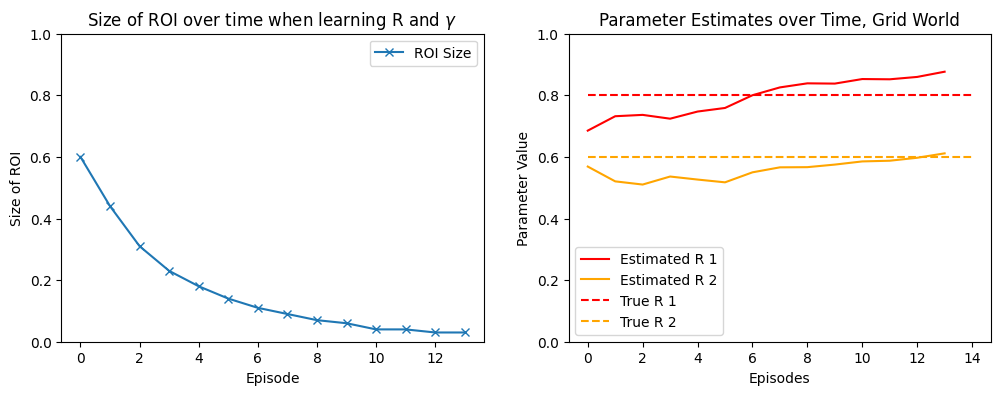

In [7]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="red", label="Estimated R 1")
axs[1].plot(params[:, 1], color="orange", label="Estimated R 2")
# axs[1].plot(params[:, 2], color="blue", label="Estimated gamma")

axs[1].hlines(true_params.R[0], 0, params.shape[0], color="red", linestyle="--", label="True R 1")
axs[1].hlines(true_params.R[1], 0, params.shape[0], color="orange", linestyle="--", label="True R 2")
# axs[1].hlines(true_params.gamma, 0, params.shape[0], color="blue", linestyle="--", label="True gamma")

axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Grid World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()